<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Market_demand_forecasting/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [39]:
# Load the dataset (adjust the file path in Colab as needed)
file_path = '/content/Ladders updated data.xlsx'
data = pd.ExcelFile(file_path)

# Load the 'Data' sheet
df = data.parse('Data')

# Display the first few rows to understand the structure
print(df.head())

  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  QTY(EA)  
0  Multy Purpose Ladder        1  
1           STEP LADDER        1  
2           STEP LADDER        1  
3           STEP LADDER        1  
4           STEP LADDER        1  


In [40]:
# Convert Billing Date to datetime
df['Billing Date'] = pd.to_datetime(df['Billing Date'])

# Extract year, month, day, and weekday
df['Year'] = df['Billing Date'].dt.year
df['Month'] = df['Billing Date'].dt.month
df['Day'] = df['Billing Date'].dt.day
df['Weekday'] = df['Billing Date'].dt.weekday  # 0=Monday, 6=Sunday

print(df[['Billing Date', 'Year', 'Month', 'Day', 'Weekday']].head())


  Billing Date  Year  Month  Day  Weekday
0   2023-02-08  2023      2    8        2
1   2022-09-22  2022      9   22        3
2   2022-09-22  2022      9   22        3
3   2022-09-22  2022      9   22        3
4   2022-10-16  2022     10   16        6


In [41]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values (example for QTY(EA))
df['QTY(EA)'].fillna(df['QTY(EA)'].median(), inplace=True)


Billing Date     0
Net Weight       0
Sales Region     0
Invoice Value    0
Material Code    0
Size             0
QTY(EA)          0
Year             0
Month            0
Day              0
Weekday          0
dtype: int64


<ipython-input-41-8a442ea6c2a9>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['QTY(EA)'].fillna(df['QTY(EA)'].median(), inplace=True)


In [42]:
# Encode Sales Region using Label Encoding
df['Sales Region Encoded'] = df['Sales Region'].astype('category').cat.codes
print(df[['Sales Region', 'Sales Region Encoded']].head())


  Sales Region  Sales Region Encoded
0           EX                     1
1           R2                     5
2           R2                     5
3           R2                     5
4           R2                     5


In [43]:
# One-hot encode the 'Size' column
size_encoded = pd.get_dummies(df['Size'], prefix='Size')

# Add one-hot encoded columns to the dataframe
df = pd.concat([df, size_encoded], axis=1)

# Encode Material Code with Label Encoding
df['Material Code Encoded'] = df['Material Code'].astype('category').cat.codes

print(df[['Size', 'Material Code', 'Material Code Encoded']].head())


                   Size      Material Code  Material Code Encoded
0  Multy Purpose Ladder  FAML0504N000N2000                      3
1           STEP LADDER  FASL3000M001L0700                     17
2           STEP LADDER  FASL3000M001L0600                     16
3           STEP LADDER  FASL2000M001N0800                      7
4           STEP LADDER  FASL3000M001L0600                     16


In [44]:
# Create lag features for past 1, 2, and 3 months
df['Lag_1'] = df['QTY(EA)'].shift(1)
df['Lag_2'] = df['QTY(EA)'].shift(2)
df['Lag_3'] = df['QTY(EA)'].shift(3)
df['Lag_6'] = df['QTY(EA)'].shift(6)
df['Lag_12'] = df['QTY(EA)'].shift(12)  # Yearly seasonality


In [45]:
# Rolling mean and standard deviation
df['Rolling_Mean_3'] = df['QTY(EA)'].rolling(window=3).mean()
df['Rolling_Std_3'] = df['QTY(EA)'].rolling(window=3).std()


In [46]:
df['Is_Holiday_Season'] = df['Month'].isin([11, 12]).astype(int)  # Example: Holiday season = Nov-Dec


In [47]:
# Calculate Invoice Value per ladder
df['Value Per Unit'] = df['Invoice Value'] / df['QTY(EA)']

print(df[['Invoice Value', 'QTY(EA)', 'Value Per Unit']].head())


   Invoice Value  QTY(EA)  Value Per Unit
0          71.50        1           71.50
1       10732.17        1        10732.17
2        9202.18        1         9202.18
3       15373.92        1        15373.92
4        9202.18        1         9202.18


In [48]:
# Aggregate monthly sales
monthly_sales = df.groupby([df['Billing Date'].dt.to_period('M')])['QTY(EA)'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales['Billing Date'] = monthly_sales['Billing Date'].dt.to_timestamp()

print(monthly_sales.head())

print(monthly_sales.tail())


  Billing Date  QTY(EA)
0   2022-04-01      623
1   2022-05-01      997
2   2022-06-01     1690
3   2022-07-01      544
4   2022-08-01      186
   Billing Date  QTY(EA)
26   2024-06-01      854
27   2024-07-01     1301
28   2024-08-01     1474
29   2024-09-01     1072
30   2024-10-01     1092


In [49]:
# One-hot encode the 'Size' column
size_encoded = pd.get_dummies(df['Size'], prefix='Size')

# Add one-hot encoded columns to the dataframe
df = pd.concat([df, size_encoded], axis=1)

# Encode Material Code with Label Encoding
df['Material Code Encoded'] = df['Material Code'].astype('category').cat.codes

print(df[['Size', 'Material Code', 'Material Code Encoded']].head())


                   Size      Material Code  Material Code Encoded
0  Multy Purpose Ladder  FAML0504N000N2000                      3
1           STEP LADDER  FASL3000M001L0700                     17
2           STEP LADDER  FASL3000M001L0600                     16
3           STEP LADDER  FASL2000M001N0800                      7
4           STEP LADDER  FASL3000M001L0600                     16


In [50]:
# Region-wise sales growth
# Replace 'Billing Month' with the actual column name containing billing month information
# Assuming 'Month' column contains the billing month information
region_monthly = df.groupby(['Sales Region', 'Month'])['QTY(EA)'].sum().reset_index()
region_monthly['Sales Growth'] = region_monthly.groupby('Sales Region')['QTY(EA)'].pct_change()

In [51]:
# Aggregate monthly sales before calling adfuller
monthly_sales = df.groupby([df['Billing Date'].dt.to_period('M')])['QTY(EA)'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales['Billing Date'] = monthly_sales['Billing Date'].dt.to_timestamp()

# Now you can perform the ADF test
result = adfuller(monthly_sales['QTY(EA)'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.8121994322765504
p-value: 0.3744220551339152


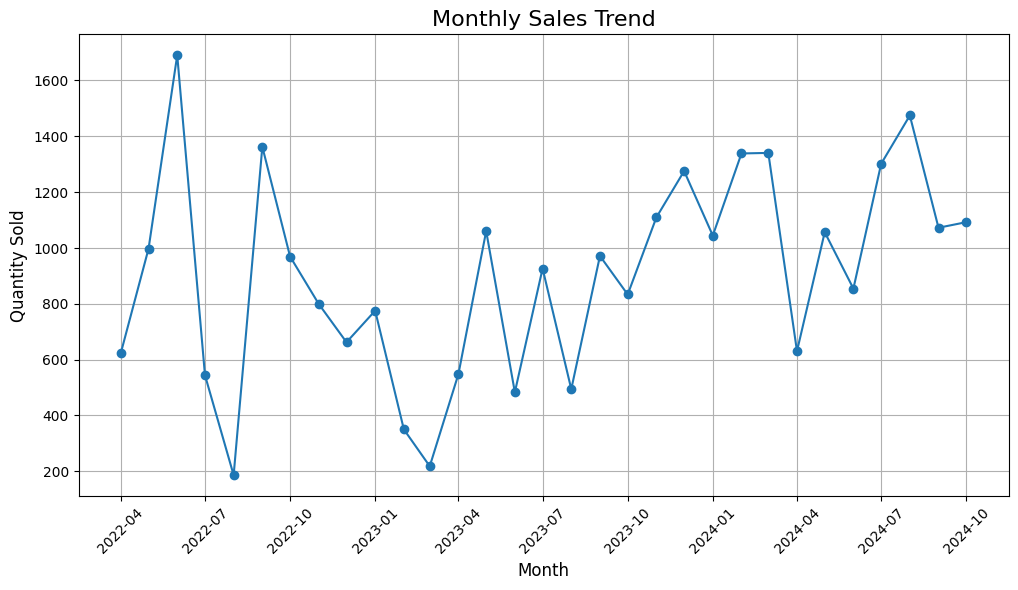

In [52]:
# Step 1: Analyze Sales Over Time
# Aggregate data by month and sum up quantities sold
df['Billing Month'] = df['Billing Date'].dt.to_period('M')
monthly_sales = df.groupby('Billing Month')['QTY(EA)'].sum().reset_index()
monthly_sales['Billing Month'] = monthly_sales['Billing Month'].dt.to_timestamp()

# Step 2: Visualize Monthly Sales Trends
plt.figure(figsize=(12, 6))
# Changed 'Billing Date' to 'Billing Month' as it's the column available after aggregation
plt.plot(monthly_sales['Billing Month'], monthly_sales['QTY(EA)'], marker='o', linestyle='-')
plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

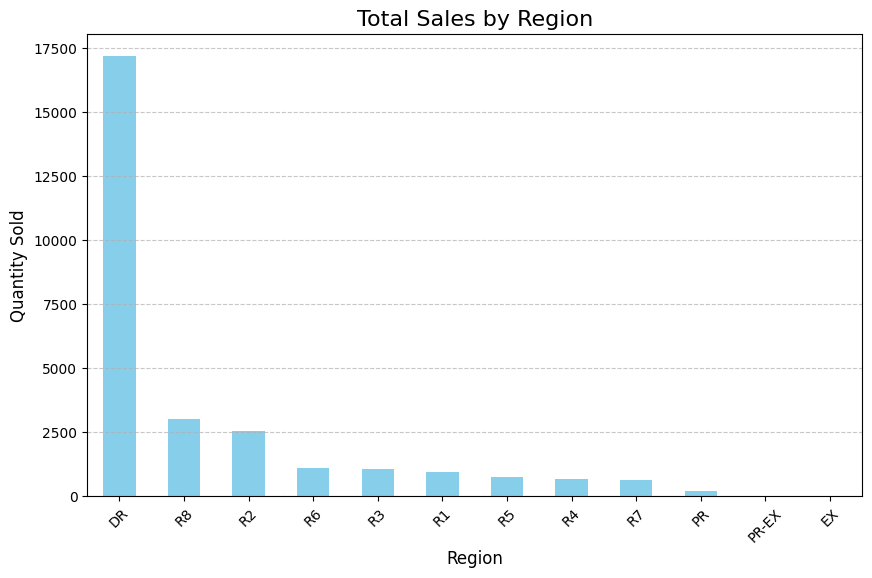

In [53]:
# Step 3: Regional Sales Analysis
region_sales = df.groupby('Sales Region')['QTY(EA)'].sum().sort_values(ascending=False)

# Step 4: Visualize Sales by Region
plt.figure(figsize=(10, 6))
region_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Region', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

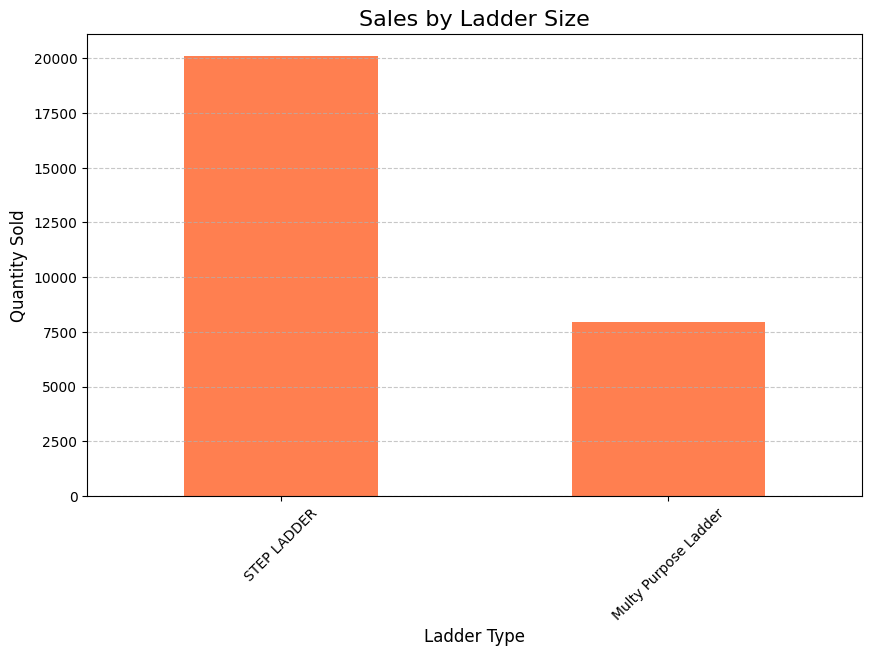

In [54]:
# Step 5: Ladder Size Analysis
size_sales = df.groupby('Size')['QTY(EA)'].sum().sort_values(ascending=False)

# Step 6: Visualize Sales by Ladder Size
plt.figure(figsize=(10, 6))
size_sales.plot(kind='bar', color='coral')
plt.title('Sales by Ladder Size', fontsize=16)
plt.xlabel('Ladder Type', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [57]:
# Set 'Billing Month' as the index, as this is the column available after aggregation
monthly_sales.set_index('Billing Month', inplace=True)

# Split data into train and test sets
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales.iloc[:train_size], monthly_sales.iloc[train_size:]

# Fit SARIMAX model
# Note: You may need to tune the (p, d, q) and (P, D, Q, S) parameters based on your data
model = SARIMAX(train['QTY(EA)'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
# Forecast on test data
forecast = model_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Evaluate the model
mae = mean_absolute_error(test['QTY(EA)'], forecast_values)
mse = mean_squared_error(test['QTY(EA)'], forecast_values)
rmse = np.sqrt(mse)
r2 = r2_score(test['QTY(EA)'], forecast_values)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

MAE: 775.9768882016988
MSE: 810920.7591478179
RMSE: 900.5113875725381
R²: -11.407538489717423


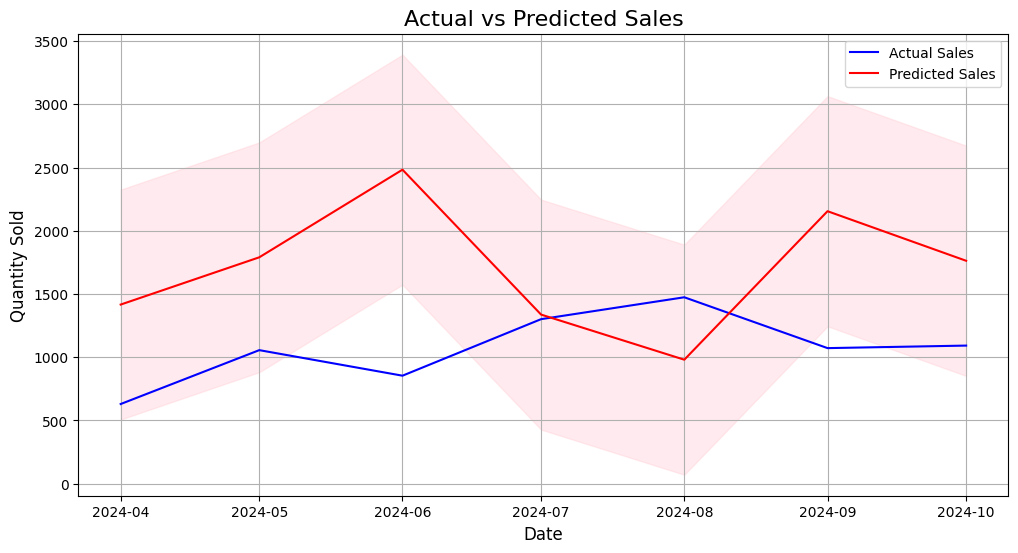

In [59]:

# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['QTY(EA)'], label='Actual Sales', color='blue')
plt.plot(test.index, forecast_values, label='Predicted Sales', color='red')
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


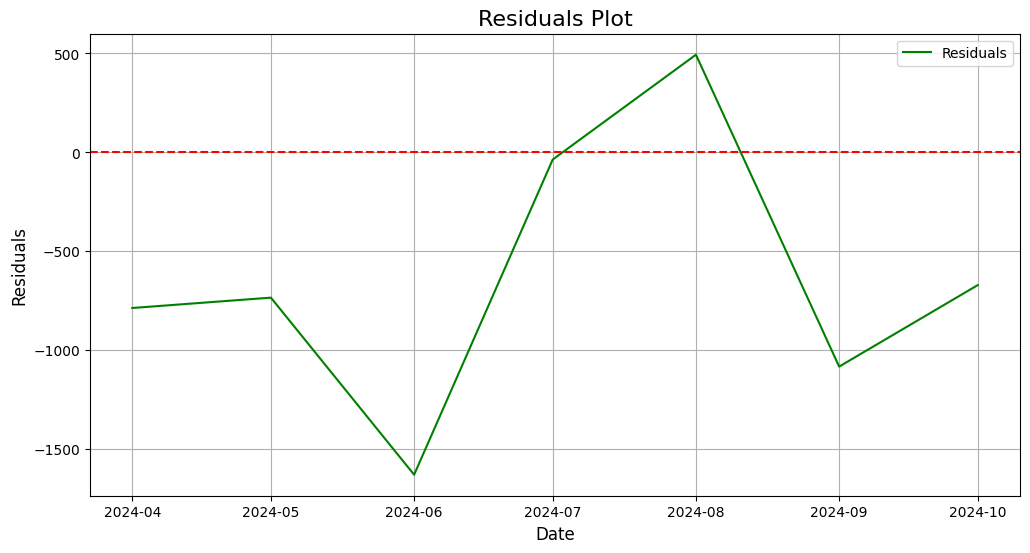

In [60]:
# Plot residuals
residuals = test['QTY(EA)'] - forecast_values
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


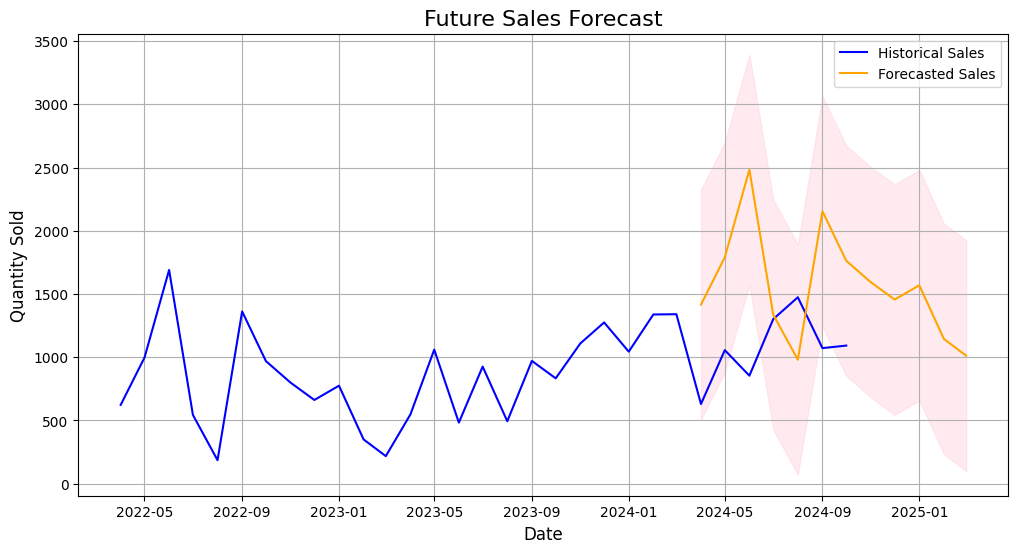

In [61]:
# Forecast future sales (e.g., next 12 months)
future_forecast = model_fit.get_forecast(steps=12)
future_values = future_forecast.predicted_mean
future_confidence_intervals = future_forecast.conf_int()

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['QTY(EA)'], label='Historical Sales', color='blue')
plt.plot(future_values.index, future_values, label='Forecasted Sales', color='orange')
plt.fill_between(future_values.index, future_confidence_intervals.iloc[:, 0], future_confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Future Sales Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [62]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Define the parameter grid
p = d = q = range(0, 2)  # Non-seasonal parameters
P = D = Q = range(0, 2)  # Seasonal parameters
S = 12  # Seasonal period (12 for monthly data)

# Generate all combinations of parameters
param_combinations = list(itertools.product(p, d, q, P, D, Q))

# Initialize variables to store the best results
best_aic = float("inf")
best_params = None

In [63]:
# Grid search
for params in param_combinations:
    try:
        # Unpack parameters
        (p_, d_, q_, P_, D_, Q_) = params

        # Fit the SARIMAX model
        model = SARIMAX(
            train['QTY(EA)'],
            order=(p_, d_, q_),
            seasonal_order=(P_, D_, Q_, S),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        # Check if this model has the best AIC
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_params = params

        print(f"Tried params: {params} | AIC: {model_fit.aic}")
    except:
        continue

print(f"\nBest params: {best_params} | Best AIC: {best_aic}")

# Refit the best model
best_p, best_d, best_q, best_P, best_D, best_Q = best_params
best_model = SARIMAX(
    train['QTY(EA)'],
    order=(best_p, best_d, best_q),
    seasonal_order=(best_P, best_D, best_Q, S),
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_model_fit = best_model.fit(disp=False)

Tried params: (0, 0, 0, 0, 0, 0) | AIC: 382.6586296099136
Tried params: (0, 0, 0, 0, 0, 1) | AIC: 182.70863275306124
Tried params: (0, 0, 0, 0, 1, 0) | AIC: 175.72213598499053
Tried params: (0, 0, 0, 0, 1, 1) | AIC: 4.0
Tried params: (0, 0, 0, 1, 0, 0) | AIC: 192.21800114383427
Tried params: (0, 0, 0, 1, 0, 1) | AIC: 179.4900727221811
Tried params: (0, 0, 0, 1, 1, 0) | AIC: 4.0
Tried params: (0, 0, 0, 1, 1, 1) | AIC: 6.0
Tried params: (0, 0, 1, 0, 0, 0) | AIC: 353.97084064746093
Tried params: (0, 0, 1, 0, 0, 1) | AIC: 161.80002293827724
Tried params: (0, 0, 1, 0, 1, 0) | AIC: 161.9785307829322
Tried params: (0, 0, 1, 0, 1, 1) | AIC: 6.0
Tried params: (0, 0, 1, 1, 0, 0) | AIC: 192.40251507252998
Tried params: (0, 0, 1, 1, 0, 1) | AIC: 161.98003734210275
Tried params: (0, 0, 1, 1, 1, 0) | AIC: 6.0
Tried params: (0, 0, 1, 1, 1, 1) | AIC: 8.0
Tried params: (0, 1, 0, 0, 0, 0) | AIC: 337.03877922690157
Tried params: (0, 1, 0, 0, 0, 1) | AIC: 149.1370819740701
Tried params: (0, 1, 0, 0, 1, 0)

In [64]:
# Forecast on test data
forecast = best_model_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Evaluate the best model
mae = mean_absolute_error(test['QTY(EA)'], forecast_values)
mse = mean_squared_error(test['QTY(EA)'], forecast_values)
rmse = np.sqrt(mse)
r2 = r2_score(test['QTY(EA)'], forecast_values)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

MAE: 310.2857142857143
MSE: 188955.42857142858
RMSE: 434.6900373500968
R²: -1.8911231170167784


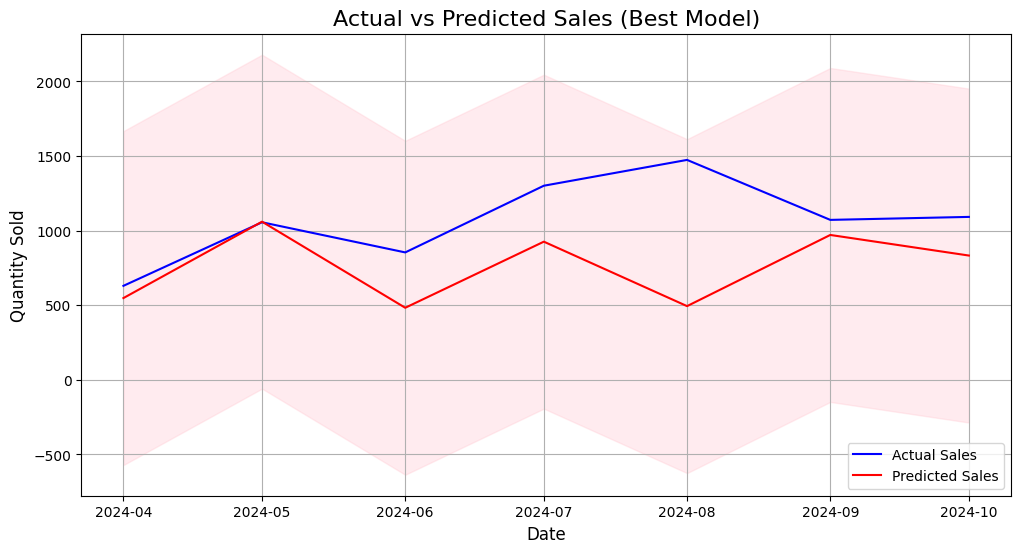

In [65]:
# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['QTY(EA)'], label='Actual Sales', color='blue')
plt.plot(test.index, forecast_values, label='Predicted Sales', color='red')
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Actual vs Predicted Sales (Best Model)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

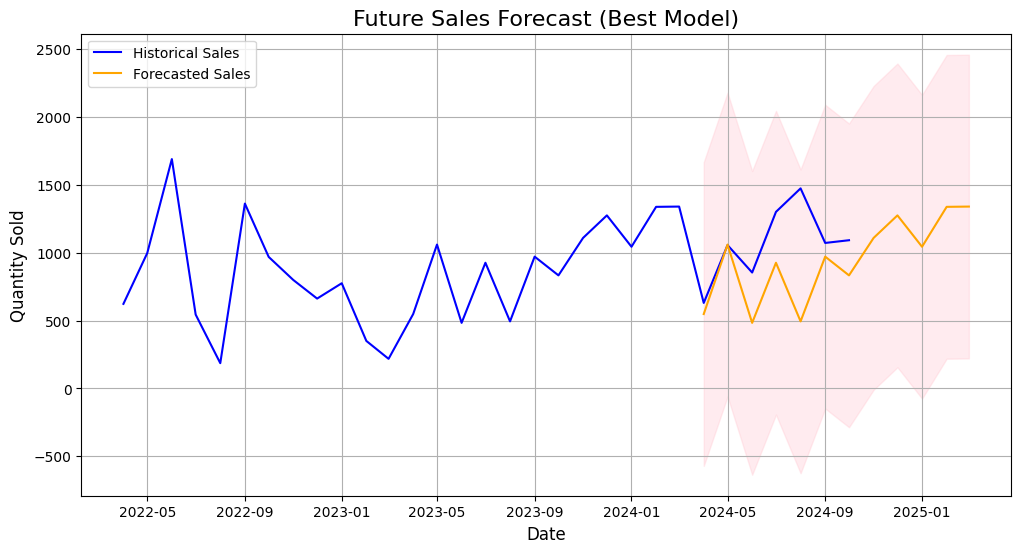

In [66]:
# Forecast future sales (e.g., next 12 months)
future_forecast = best_model_fit.get_forecast(steps=12)
future_values = future_forecast.predicted_mean
future_confidence_intervals = future_forecast.conf_int()

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['QTY(EA)'], label='Historical Sales', color='blue')
plt.plot(future_values.index, future_values, label='Forecasted Sales', color='orange')
plt.fill_between(future_values.index, future_confidence_intervals.iloc[:, 0], future_confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Future Sales Forecast (Best Model)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Add Fourier terms for seasonality
from statsmodels.tsa.deterministic import Fourier

fourier = Fourier(period=12, order=4)  # 12 for monthly data, order 4 for 4 Fourier terms
fourier_features = fourier.in_sample(train.index)
train = pd.concat([train, fourier_features], axis=1)
test = pd.concat([test, fourier_features], axis=1)

# Add holiday indicators (example: December is a holiday month)
train['Is_Holiday'] = train.index.month == 12
test['Is_Holiday'] = test.index.month == 12

In [68]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [69]:
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the parameters
    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 2)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 2)
    Q = trial.suggest_int('Q', 0, 2)
    S = 12  # Seasonal period

    try:
        # Fit the SARIMAX model
        model = SARIMAX(
            train['QTY(EA)'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, S),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        # Forecast on test data
        forecast = model_fit.get_forecast(steps=len(test))
        forecast_values = forecast.predicted_mean

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test['QTY(EA)'], forecast_values))
        return rmse
    except:
        return float('inf')  # Return a large value if the model fails

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print(f"Best parameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

# Refit the best model
best_params = study.best_params
best_model = SARIMAX(
    train['QTY(EA)'],
    order=(best_params['p'], best_params['d'], best_params['q']),
    seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_model_fit = best_model.fit(disp=False)

[I 2025-02-02 19:25:40,296] A new study created in memory with name: no-name-adff404b-1993-48fc-bc29-8a34832447c9
[I 2025-02-02 19:25:40,370] Trial 0 finished with value: inf and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 0, 'D': 2, 'Q': 1}. Best is trial 0 with value: inf.
[I 2025-02-02 19:25:40,524] Trial 1 finished with value: inf and parameters: {'p': 2, 'd': 2, 'q': 2, 'P': 2, 'D': 1, 'Q': 1}. Best is trial 0 with value: inf.
[I 2025-02-02 19:25:40,585] Trial 2 finished with value: inf and parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 1, 'D': 2, 'Q': 0}. Best is trial 0 with value: inf.
[I 2025-02-02 19:25:40,638] Trial 3 finished with value: inf and parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 0, 'D': 2, 'Q': 1}. Best is trial 0 with value: inf.
[I 2025-02-02 19:25:41,187] Trial 4 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 0, 'P': 2, 'D': 2, 'Q': 0}. Best is trial 0 with value: inf.
[I 2025-02-02 19:25:41,276] Trial 5 finished with value: inf and parameters: {'p': 1, 

Best parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 0, 'D': 2, 'Q': 1}
Best RMSE: inf


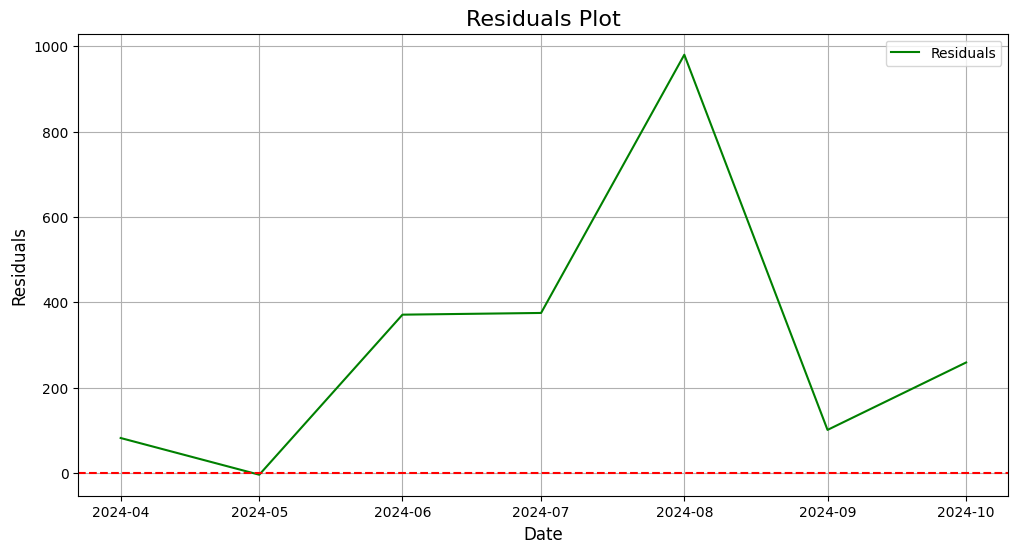

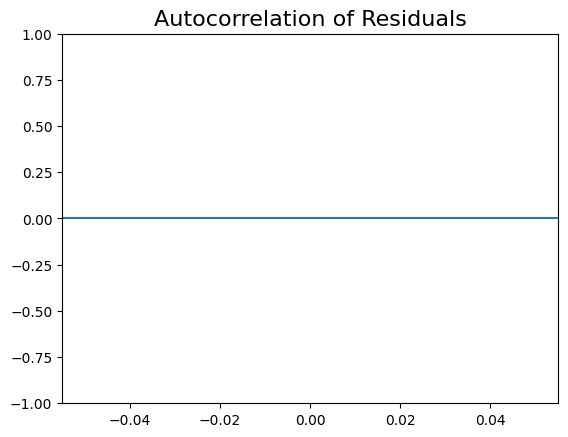

In [70]:
# Calculate residuals
residuals = test['QTY(EA)'] - forecast_values

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Check for autocorrelation in residuals
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals', fontsize=16)
plt.show()

In [73]:
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

MAE: 310.2857142857143
MSE: 188955.42857142858
RMSE: 434.6900373500968
R²: -1.8911231170167784


In [75]:
from xgboost import XGBRegressor

# Prepare data for XGBoost
X_train = train.drop(columns=['QTY(EA)'])
y_train = train['QTY(EA)']
X_test = test.drop(columns=['QTY(EA)'])
y_test = test['QTY(EA)']

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Get XGBoost predictions
xgb_forecast = xgb_model.predict(X_test)

# Ensure xgb_forecast is a pandas Series with the correct index
xgb_forecast = pd.Series(xgb_forecast, index=test.index)

# Reindex 'forecast_values' to align with the test set index if needed
forecast_values = forecast_values.reindex(test.index)

# Handle potential NaNs in forecast_values and xgb_forecast
# Replace NaNs with 0 or another appropriate value
forecast_values = forecast_values.fillna(0)
xgb_forecast = xgb_forecast.fillna(0)

# Now you can combine the predictions
ensemble_forecast = (forecast_values + xgb_forecast) / 2

# Before calculating RMSE, drop rows with NaN values in the target variable
# This ensures that only valid data points are used for evaluation
test_no_nan = test.dropna(subset=['QTY(EA)'])
ensemble_forecast_no_nan = ensemble_forecast[test_no_nan.index]  # Align ensemble forecast

# Evaluate ensemble model
ensemble_rmse = np.sqrt(mean_squared_error(test_no_nan['QTY(EA)'], ensemble_forecast_no_nan))
print(f'Ensemble RMSE: {ensemble_rmse}')

Ensemble RMSE: 303.1433484864749


In [76]:
from sklearn.model_selection import TimeSeriesSplit

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation
rmse_scores = []
for train_index, test_index in tscv.split(monthly_sales):
    train_cv, test_cv = monthly_sales.iloc[train_index], monthly_sales.iloc[test_index]
    model = SARIMAX(train_cv['QTY(EA)'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=len(test_cv))
    forecast_values = forecast.predicted_mean
    rmse = np.sqrt(mean_squared_error(test_cv['QTY(EA)'], forecast_values))
    rmse_scores.append(rmse)

print(f'Cross-Validation RMSE: {np.mean(rmse_scores)}')

Cross-Validation RMSE: 609.159397233783
